<h1> Analysis on Gluttony Sin </h1>

<h3> Input :</h3>
<ol type="1">
  <li>Twitter json file (as requested to the couchdb)</li>  
  <li>Victoria geojson file to get the area based on coordinate</li>      
  <li>List of most common food hashtag to flag the gluttony tweet</li>    
  <li>List of most common word appeared in food-related text to filter the entity in tweet to get list of food names</li>        
</ol>

<h3> Process :</h3>
<ol type="1">
  <li>Filter twitter json file to get the intended attributes</li>  
  <li>Flag twitter with gluttony sin if it contains most common food hashtag</li>      
  <li>Process the flagged twitter to extract all important features (such as normalized token, hashtag, emoticon, noun, etc.</li>    
  <li>Summarize the features in total and per area </li>        
</ol>

<h3> Output :</h3>
<h4> Json file for these Statistics both in aggregate and per area</h4>
<ol type="1">
  <li>Frequency of gluttony twitter, tweet contain picture, and retweet </li>   
  <li>Frequency of each hashtag </li>    
  <li>Frequency of each emoticons </li>        
  <li>Frequency of each tokens after normalization process</li>
  <li>Frequency of each noun to extract food types</li>
  <li>Frequency of gluttony tweet based on favorite count category</li>   
  <li>Frequency of gluttony tweet based on follower count category</li>  
  <li>Frequency of gluttony tweet based on friend count category</li>    
  <li>Frequency of gluttony tweet based on status count category</li> 
  <li>Frequency of gluttony tweet based on month when it is posted</li>   
  <li>Frequency of gluttony tweet based on time when it is posted</li>       
  <li>Frequency of gluttony tweet based on place when user register twitter account</li>   
</ol>

In [554]:
import requests, json, os, csv, emoji, nltk, re, string
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from requests.auth import HTTPBasicAuth
from shapely.geometry import Polygon
from shapely.geometry import Point
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk import bigrams 
from emoji import UNICODE_EMOJI
from textblob import TextBlob    
    
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
punctuation = list(set(string.punctuation))

In [390]:
# parameters to connect to the dataset
url = "http://45.113.232.90/couchdbro/twitter/_design/twitter/_view/summary"
city = "melbourne"
start_date = "2015-1-1"
end_date = "2016-12-31"
userauth1 = "readonly"
userauth2 = "ween7ighai9gahR6"

# read_file
geojson = "melbourne_territory.json"
foodtag = "food_hashtag.txt"
commonword = "food_common_word.txt"

#adjusted stopword
stopword = stopwords.words('english') + punctuation + ['rt','via', 's']

In [12]:
def get_connect(url, city, start_date, end_date, userauth1,userauth2):
    payload = {}
    payload["start_key"] = "[\"" + city + "\"," + start_date.split("-")[0] + "," + start_date.split("-")[1] + "," + start_date.split("-")[2] + "]"
    payload["end_key"] = "[\"" + city + "\"," + end_date.split("-")[0] + "," + end_date.split("-")[1] + "," + end_date.split("-")[2] + "]"
    payload["reduce"] = "false"
    payload["include_docs"] = "true"
    uname = HTTPBasicAuth(userauth1,userauth2)
    request = requests.get(url, stream=True, params=payload, auth=uname)
    return request

In [ ]:
def read_file(file):
    data = []
    with open(file, "r") as txtfile:
        for line in txtfile:
            data.append(line.strip())
    return data

In [566]:
class get_data:
    def __init__(self,request,area):  
        self.userid          = []
        self.place_register  = []
        self.status_count    = []
        self.retweet_count   = []
        self.follower_count  = []
        self.friend_count    = []
        self.favorite_count  = []
        self.screen_name     = []
        self.month_post      = []
        self.time_post       = []
        self.year_post       = []
        self.tweet_text      = []
        self.area            = []
        self.mention         = []
        self.media           = []
        for line in request.iter_lines():
            tweet = line.decode('utf-8').strip()
            if tweet.startswith("{\"id\":"):
                json_tweet = ""
                if tweet.endswith(","):
                    json_tweet = json.loads(tweet[0:-1])
                else:
                    json_tweet = json.loads(tweet)
                self.userid.append(json_tweet['doc']['user']['id'])
                self.place_register.append(json_tweet['doc']['user']['time_zone'])
                self.status_count.append(json_tweet['doc']['user']['statuses_count'])
                self.retweet_count.append(json_tweet['doc']['retweet_count'])
                self.follower_count.append(json_tweet['doc']['user']['followers_count'])
                self.friend_count.append(json_tweet['doc']['user']['friends_count'])
                self.favorite_count.append(json_tweet['doc']['user']['favourites_count'])
                self.screen_name.append(json_tweet['doc']['user']['screen_name'])
                self.month_post.append(json_tweet['key'][2])
                self.time_post.append(json_tweet['doc']['created_at'].split()[3])
                self.year_post.append(json_tweet['doc']['created_at'].split()[5])
                self.tweet_text.append(json_tweet['doc']['text'])
                coor = json_tweet['doc']['coordinates']['coordinates']
                self.area.append(area.tag(coor[0], coor[1]))                
                mentions = len(json_tweet['doc']['entities']['user_mentions'])
                if mentions > 0:
                    self.mention.append([json_tweet['doc']['entities']['user_mentions'][x]['screen_name'].lower() for x in range(mentions)])
                else:
                    self.mention.append([''])
                try:
                    medias = json_tweet['doc']['entities']['media']
                    self.media.append([medias[x]['type'] for x in range(len(medias))])
                except:
                    self.media.append([''])   

class VicArea:
    def __init__(self, geojson):
        self.geojson = geojson
        self.teritories = {}
        self.centers = {}
        self.area_names = {}
        
        with open(self.geojson, encoding="utf8") as jsonfile:
            raw_grid = json.load(jsonfile)
            for teritory in raw_grid["features"]:
                polygon = Polygon(teritory["geometry"]["coordinates"][0][0])
                # k = teritory["properties"]["vic_lga__2"]
                k = teritory["properties"]["lga_pid"]
                if k not in self.teritories:
                    self.teritories[k] = []
                self.teritories[k].append(polygon)
                self.area_names[k] = teritory["properties"]["vic_lga__2"]
        
        for t in self.teritories:
            if len(self.teritories[t]) > 1:
                self.teritories[t].sort(key=lambda x:x.area, reverse=True)
            self.centers[t] = self.teritories[t][0].centroid
    
    def tag(self, x, y):
        # returns empty string if location is outside the whole grids
        # returns area label in LGA PID format
        test_point = Point(x, y)
        tag = ""
        for ter in self.teritories:
            for t in self.teritories[ter]:
                if test_point.within(t):
                    return ter
        return tag
    
    def name(self, tag):
        try:
            return self.area_names[tag]
        except KeyError:
            return "NON-VICTORIA"
        
class text_processing:
    def __init__(self,twitter,index):
        global stopword
        global common_word
        text = twitter.tweet_text[index].lower()
        self.length = len(text)
        if twitter.mention[index] != ['']:
            for user in twitter.mention[index]:
                user = user.lower()
                text = re.sub(r'@'+user+'\s','',text)
        text = re.sub(r"http\S+", "", text)        
        self.hashtag = [h for h in re.findall(r"#(\w+)", text)] 
        text = re.sub(r"#(\w+)", "", text)  
        tblob = TextBlob(text)
        self.polarity = tblob.sentiment.polarity
        text = word_tokenize(text) 
        self.emoji = [e for e in text if e in UNICODE_EMOJI]      
        for i in range(len(text)):
            lemma = lemmatizer.lemmatize(text[i],'v')
            if lemma == text[i]:
                lemma = lemmatizer.lemmatize(text[i],'n')
            text[i] = lemma        
        text = ' '.join(text)
        text = re.sub(r"[^\w\s]","",text)  
        text = text.split()
        text = [w for w in text if w not in stopword]  
        tag = nltk.pos_tag(text)
        self.noun = [tag[i][0] for i in range(len(tag)) if tag[i][1]=='NN' and tag[i][0] not in common_word]
        self.token = text 

In [573]:
def count_category(count):
    if count <50:
        return '<50'
    elif count >= 50 and count <100:
        return '50-100'
    elif count >= 100 and count <200:
        return '100-200'
    elif count >= 200 and count <500:
        return '200-500'
    elif count >= 500 and count <1000:
        return '500-1000'
    elif count >= 1000 and count <2000:
        return '1000-2000'
    elif count >= 2000 and count <5000:
        return '2000-5000'
    elif count >= 5000:
        return '>5000'

def time_category(time):
    if time >= 5 and time <= 8:
        return 'Early morning'
    elif time >= 9 and time <= 10:
        return 'Morning'
    elif time == 11:
        return 'Late Morning'
    elif time >= 12 and time <= 15:
        return 'Early Afternoon'
    elif time >= 16 and time <= 17:
        return 'Late Afternoon'
    elif time >= 18 and time <= 19:
        return 'Early Evening'
    elif time >= 20 and time <= 21:
        return 'Evening'
    else:
        return 'Night'
    
def vertical_bar(height,bars,color_desc):
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height, color = color_desc)
    plt.xticks(y_pos, bars)
    plt.show()   

def horizontal_bar(height,bars,color_desc):
    y_pos = np.arange(len(bars))
    plt.barh(y_pos, height, color = color_desc)
    plt.yticks(y_pos, bars)
    plt.gca().invert_yaxis()
    plt.show()
    
def wordcloud(freq):
    wcloud = WordCloud(background_color='white').generate_from_frequencies(freq)
    plt.imshow(wcloud,  interpolation='bilinear')
    plt.axis("off")
    (-0.5, 399.5, 199.5, -0.5)
    plt.show()

In [543]:
# connect to the data source
request = get_connect(url, city, start_date, end_date, userauth1,userauth2)

In [558]:
# get related file
food_hashtag = os.path.join(os.path.dirname(os.path.realpath('__file__')), foodtag)
main_hashtag = read_file(food_hashtag)
food_common_word = os.path.join(os.path.dirname(os.path.realpath('__file__')), commonword)
common_word = read_file(food_common_word)

In [545]:
# get the polygon of victoria
filename = os.path.join(os.path.dirname(os.path.realpath('__file__')), geojson)
victoria = VicArea(filename)

In [546]:
# get the twitter data
twitter = get_data(request,victoria)

<h3> Total number of raw tweet from nectar couch db 2015 - 2016 </h3>

<b>findings</b>: not large enough, need more data from streaming Twitter API

In [548]:
# number of raw tweet data
len(twitter.area)

209059

In [567]:
# process the tweet for aggregate statistics
agg_tweet_token = {}
agg_tweet_hashtag = {}
agg_tweet_emoji = {}
agg_tweet_noun = {}
agg_tweet_polarity = {}
agg_tweet_area = {}
agg_favorite_cat = {}
agg_follower_cat = {}
agg_friend_cat = {}
agg_month_cat = {}
agg_status_cat = {}
agg_place_register = {}
agg_time_post = {}
agg_retweet = 0
agg_photo = 0
agg_tweet_count = 0
tweet_index = []
for i in range(len(twitter.tweet_text)):
    tweet = twitter.tweet_text[i]
    found = 0
    for tag in main_hashtag:
        tags = [h.lower() for h in re.findall(r"#(\w+)", tweet)] 
        if tag.lower() in tags:
            found = 1
            break
    if found == 1:
        agg_tweet_count += 1
        
        if twitter.media[i] != ['']:
            for media in twitter.media[i]:
                if media == 'photo':
                    agg_photo += 1
        
        if twitter.retweet_count[i] > 0:
            agg_retweet += 1
            
        area = victoria.name(twitter.area[i])
        agg_tweet_area[area] = agg_tweet_area.get(area,0) + 1
        
        favcat = count_category(twitter.favorite_count[i])
        agg_favorite_cat[favcat] = agg_favorite_cat.get(favcat,0) + 1
        
        folcat = count_category(twitter.follower_count[i])
        agg_follower_cat[folcat] = agg_follower_cat.get(folcat,0) + 1  
        
        frcat = count_category(twitter.friend_count[i])
        agg_friend_cat[frcat] = agg_friend_cat.get(frcat,0) + 1
        
        stcat = count_category(twitter.status_count[i])
        agg_status_cat[stcat] = agg_status_cat.get(stcat,0) + 1
        
        agg_month_cat[twitter.month_post[i]] = agg_month_cat.get(twitter.month_post[i],0) + 1
        
        agg_place_register[twitter.place_register[i]] = agg_place_register.get(twitter.place_register[i],0) + 1
        
        tcat = time_category(int(twitter.time_post[i][:2]))
        agg_time_post[tcat] = agg_time_post.get(tcat,0) + 1
        
        process = text_processing(twitter,i)
        for token in process.token:
            agg_tweet_token[token] = agg_tweet_token.get(token,0) + 1
            
        for hashtag in process.hashtag:
            agg_tweet_hashtag[hashtag] = agg_tweet_hashtag.get(hashtag,0) + 1  
            
        for emoji in process.emoji:
            agg_tweet_emoji[emoji] = agg_tweet_emoji.get(emoji,0) + 1  
            
        for noun in process.noun:
            agg_tweet_noun[noun] = agg_tweet_noun.get(noun,0) + 1  
            
        if process.polarity > 0:
            agg_tweet_polarity['positive'] = agg_tweet_polarity.get('positive',0) + 1
        elif process.polarity < 0:
            agg_tweet_polarity['negative'] = agg_tweet_polarity.get('negative',0) + 1
        else:
            agg_tweet_polarity['neutral'] = agg_tweet_polarity.get('neutral',0) + 1
       
        tweet_index.append(i)
        
    else:
        continue      

<h3>Frequencies </h3>

<b>findings</b>: from 209059 record there are only 1466 marked as Gluttony Tweet
<p>proportion of Tweet with image is so low, if we want to do image classification we need to harvest a very large tweet record</p>

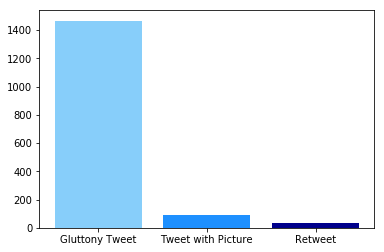

In [605]:
# frequency
height = [agg_tweet_count, agg_photo, agg_retweet]
bars = ['Gluttony Tweet', 'Tweet with Picture', 'Retweet']
color = ['lightskyblue', 'dodgerblue', 'darkblue']
vertical_bar(height,bars,color)

<h3> Distribution of Gluttony Twitter Based on Areas </h3>

<b>findings</b>: Big cities returns higher frequencies

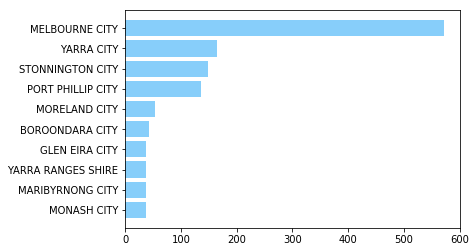

In [568]:
# area
common_area = sorted(agg_tweet_area.items(), key=lambda x: x[1], reverse = True)
height = [common_area[i][1] for i in range(len(common_area))][:10]
bars = [common_area[i][0] for i in range(len(common_area))][:10]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h3> Most Common Hashtags in Gluttony Twitter  </h3>

<b>findings</b>: Most likely returns the hashtag in flag list, but other hashtags that is not in the list can be added to detect more gluttony tweets

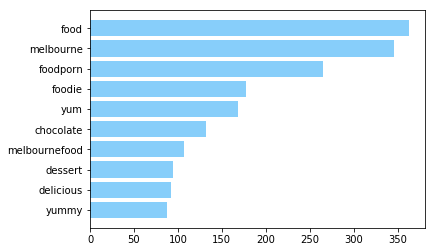

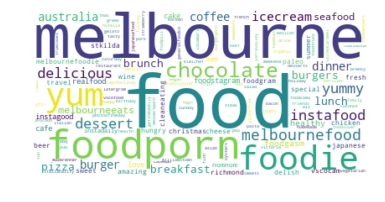

In [564]:
# hashtag
common_hashtag = sorted(agg_tweet_hashtag.items(), key=lambda x: x[1], reverse = True)  
height = [common_hashtag[i][1] for i in range(len(common_hashtag))][:10]
bars = [common_hashtag[i][0] for i in range(len(common_hashtag))][:10]
color = 'lightskyblue'
horizontal_bar(height,bars,color)
wordcloud(agg_tweet_hashtag)

<h3> Most Common Emoticons in Gluttony Twitter  </h3>

<b>findings</b>: Most likely returns food emoticons, can be used as gluttony flag

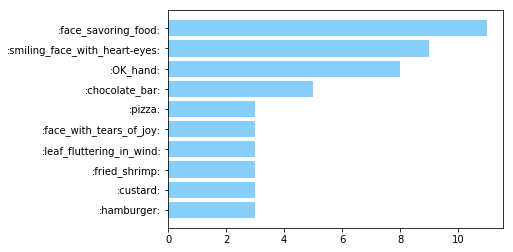

In [556]:
# emoticons
common_emoji = sorted(agg_tweet_emoji.items(), key=lambda x: x[1], reverse = True)
height = [common_emoji[i][1] for i in range(len(common_emoji))][:10]
bars = [emoji.demojize(common_emoji[i][0]) for i in range(len(common_emoji))][:10]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h3> Most Common Noun Words in Gluttony Twitter  </h3>

<b>findings</b>: Returns various food types that assumed correlate with people's consumption
<p><b>ideas</b>: good for food businesses</p>
<p><b>future work</b>: try to capture on bigram</p>

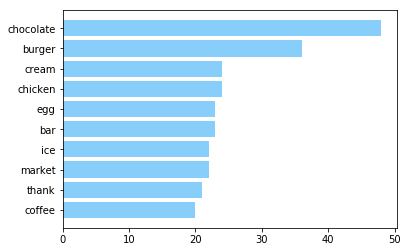

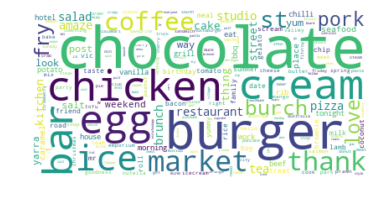

In [569]:
# noun
common_noun = sorted(agg_tweet_noun.items(), key=lambda x: x[1], reverse = True)
height = [common_noun[i][1] for i in range(len(common_noun))][:10]
bars = [common_noun[i][0] for i in range(len(common_noun))][:10]
color = 'lightskyblue'
horizontal_bar(height,bars,color)
wordcloud(agg_tweet_noun)

<h3> Sentiment Analysis in Gluttony Twitter  </h3>

<b>findings</b>: Despite the neutral, most likely have positive sentiments over food

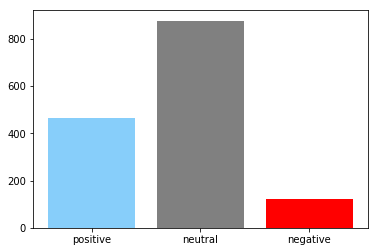

In [570]:
# sentiment analysis
height = list(agg_tweet_polarity.values())
bars = list(agg_tweet_polarity.keys())
color = ['lightskyblue', 'grey', 'red']
vertical_bar(height,bars,color)

In [577]:
x1 = '<50'
x2 = '50-100'
x3 = '100-200'
x4 = '200-500'
x5 = '500-1000'
x6 = '1000-2000'
x7 = '2000-5000'
x8 = '>5000'

<h3> Distribution of Users Favorite Count  </h3>

<b>findings</b>: Gluttony users less likely to mark favorite tweets (could be focus on themselves)

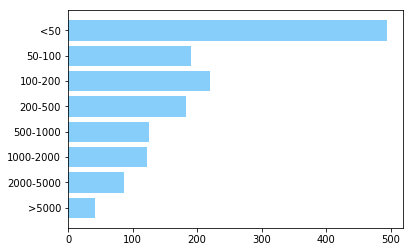

In [602]:
# favorite count
height = [agg_favorite_cat[x1],agg_favorite_cat[x2],agg_favorite_cat[x3],agg_favorite_cat[x4], \
       agg_favorite_cat[x5],agg_favorite_cat[x6],agg_favorite_cat[x7],agg_favorite_cat[x8]]
bars = [x1,x2,x3,x4,x5,x6,x7,x8]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h3> Distribution of Follower Count  </h3>

<b>findings</b>: Most likely have many followers

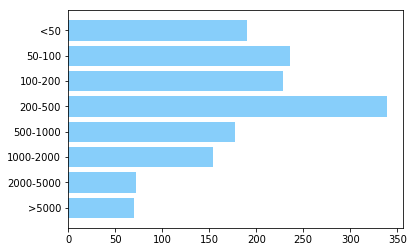

In [601]:
# follower count
height = [agg_follower_cat[x1],agg_follower_cat[x2],agg_follower_cat[x3],agg_follower_cat[x4], \
       agg_follower_cat[x5],agg_follower_cat[x6],agg_follower_cat[x7],agg_follower_cat[x8]]
bars = [x1,x2,x3,x4,x5,x6,x7,x8]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h3> Distribution of Friend Count  </h3>

<b>findings</b>: Most likely have many friends

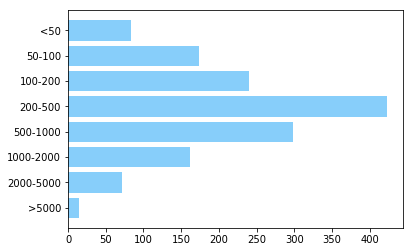

In [580]:
# friend count
height = [agg_friend_cat[x1],agg_friend_cat[x2],agg_friend_cat[x3],agg_friend_cat[x4], \
       agg_friend_cat[x5],agg_friend_cat[x6],agg_friend_cat[x7],agg_friend_cat[x8]]
bars = [x1,x2,x3,x4,x5,x6,x7,x8]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h3> Distribution of Status Count  </h3>

<b>findings</b>: Definitely, love update status

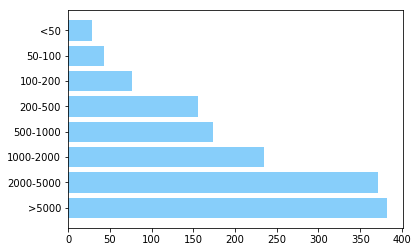

In [581]:
# status count
height = [agg_status_cat[x1],agg_status_cat[x2],agg_status_cat[x3],agg_status_cat[x4], \
       agg_status_cat[x5],agg_status_cat[x6],agg_status_cat[x7],agg_status_cat[x8]]
bars = [x1,x2,x3,x4,x5,x6,x7,x8]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h3> Distribution of Post Based on Month  </h3>

<b>findings</b>: Wonder why there is no post captured from April to July, is the harvester off at that time?

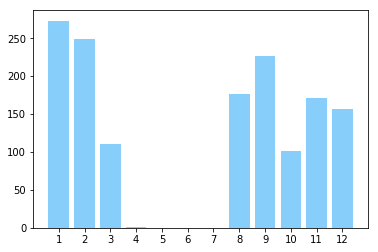

In [585]:
# month
height = [agg_month_cat.get(1,0),agg_month_cat.get(2,0),agg_month_cat.get(3,0),agg_month_cat.get(4,0), \
          agg_month_cat.get(5,0),agg_month_cat.get(6,0),agg_month_cat.get(7,0),agg_month_cat.get(8,0), \
          agg_month_cat.get(9,0), agg_month_cat.get(10,0), agg_month_cat.get(11,0), agg_month_cat.get(12,0)]
bars = [1,2,3,4,5,6,7,8,9,10,11,12]
color = 'lightskyblue'
vertical_bar(height,bars,color)

<h3> Distribution of Post Based Place When They Register on Twitter  </h3>

<b>findings</b>: Majority are from Australia, but there are some other places which shows how vary people in Victoria is

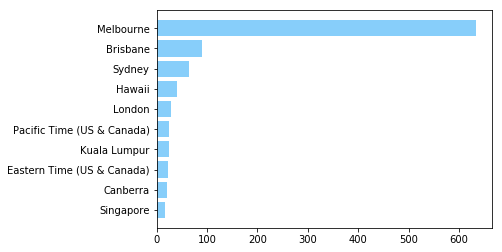

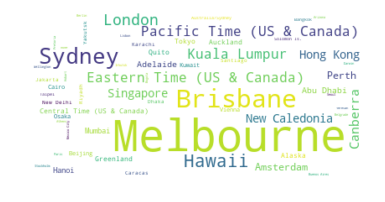

In [592]:
# place register
pr = agg_place_register.copy()
pr.pop(None)
common_place = sorted(pr.items(), key=lambda x: x[1], reverse = True)
height = [common_place[i][1] for i in range(len(common_place))][:10]
bars = [common_place[i][0] for i in range(len(common_place))][:10]
color = 'lightskyblue'
horizontal_bar(height,bars,color)
wordcloud(pr)

<h3> Distribution of Post Based on Time  </h3>

<b>findings</b>: Definitely, majority post at dinner time

In [595]:
t1 = 'Early Morning'
t2 = 'Morning'
t3 = 'Late Morning'
t4 = 'Early Afternoon'
t5 = 'Late Afternoon'
t6 = 'Early Evening'
t7 = 'Evening'
t8 = 'Night'

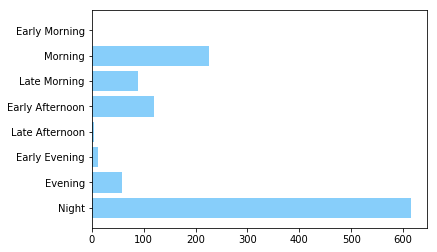

In [596]:
# time post
height = [agg_time_post.get(t1,0),agg_time_post.get(t2,0),agg_time_post.get(t3,0),agg_time_post.get(t4,0), \
          agg_time_post.get(t5,0),agg_time_post.get(t6,0),agg_time_post.get(t7,0),agg_time_post.get(t8,0)]
bars = [t1,t2,t3,t4,t5,t6,t7,t8]
color = 'lightskyblue'
horizontal_bar(height,bars,color)

<h2> Data For Map Visualization Aggregared By Area Code According to Geojson</h2>

Every are has the same statistics as the aggregate ones, but for data with frequencies only returns the top ten, and there is no frequency of number of Twitter with pics and number of Retweet

In [608]:
area_list = victoria.area_names.keys()
stat_area = {}
for area in area_list:
    tweet_count = 0    
    tweet_token = {}
    tweet_hashtag = {}
    tweet_emoji = {}
    tweet_noun = {}
    tweet_polarity = {}
    favorite_cat = {}
    follower_cat = {}
    friend_cat = {}
    month_cat = {}
    status_cat = {}
    place_register = {}
    time_post = {}
    for i in tweet_index: 
        if twitter.area[i] == area:
            tweet = twitter.tweet_text[i]
            tweet_count += 1

            favcat = count_category(twitter.favorite_count[i])
            favorite_cat[favcat] = favorite_cat.get(favcat,0) + 1

            folcat = count_category(twitter.follower_count[i])
            follower_cat[folcat] = follower_cat.get(folcat,0) + 1  

            frcat = count_category(twitter.friend_count[i])
            friend_cat[frcat] = friend_cat.get(frcat,0) + 1

            stcat = count_category(twitter.status_count[i])
            status_cat[stcat] = status_cat.get(stcat,0) + 1

            month_cat[twitter.month_post[i]] = month_cat.get(twitter.month_post[i],0) + 1

            place_register[twitter.place_register[i]] = place_register.get(twitter.place_register[i],0) + 1

            tcat = time_category(int(twitter.time_post[i][:2]))
            time_post[tcat] = time_post.get(tcat,0) + 1

            process = text_processing(twitter,i)
            for token in process.token:
                tweet_token[token] = tweet_token.get(token,0) + 1

            for hashtag in process.hashtag:
                tweet_hashtag[hashtag] = tweet_hashtag.get(hashtag,0) + 1  

            for emoji in process.emoji:
                tweet_emoji[emoji] = tweet_emoji.get(emoji,0) + 1  

            for noun in process.noun:
                tweet_noun[noun] = tweet_noun.get(noun,0) + 1  

            if process.polarity > 0:
                tweet_polarity['positive'] = tweet_polarity.get('positive',0) + 1
            elif process.polarity < 0:
                tweet_polarity['negative'] = tweet_polarity.get('negative',0) + 1
            else:
                tweet_polarity['neutral'] = tweet_polarity.get('neutral',0) + 1
        else:
            continue
            
    common_token = sorted(tweet_token.items(), key=lambda x: x[1], reverse = True)[:10]
    common_hashtag = sorted(tweet_hashtag.items(), key=lambda x: x[1], reverse = True)[:10]
    common_emoji = sorted(tweet_emoji.items(), key=lambda x: x[1], reverse = True)[:10]
    common_noun = sorted(tweet_noun.items(), key=lambda x: x[1], reverse = True)[:10]
    common_register = sorted(place_register.items(), key=lambda x: x[1], reverse = True)[:10]
    
    area_name = victoria.name(area)   
    
    stat_area[area] = {'area_name' : area_name, \
                       'freq_gluttony' : tweet_count, \
                       'top_term' : common_token, \
                       'top_hashtag' : common_hashtag, \
                       'top_emoticon' : common_emoji, \
                       'top_noun' : common_noun, \
                       'sentiment' : tweet_polarity, \
                       'favorite_count' : favorite_cat, \
                       'follower_count' : follower_cat, \
                       'friend_count' : friend_cat, \
                       'status_count' : status_cat, \
                       'origin' : common_register, 
                       'month_post' : month_cat, \
                       'time_post' : time_post}
  

In [415]:
for area in stat_area.keys():
    if stat_area[area]['freq_gluttony'] > 0:
        print(area,stat_area[area]['freq_gluttony'], \
              stat_area[area]['top_hashtag'][:1], \
              stat_area[area]['top_emoticon'][:1], \
              stat_area[area]['top_noun'][:1])

VIC221 8 [('food', 3)] [('🍕', 1)] [('cook', 1)]
VIC226 11 [('food', 6)] [] [('christ', 3)]
VIC227 4 [('food', 2)] [] [('dinner', 2)]
VIC189 2 [('vegetarian', 1)] [] [('colour', 1)]
VIC205 28 [('chocolate', 9)] [('😜', 1)] [('chocolate', 6)]
VIC206 38 [('chocolate', 13)] [('💜', 1)] [('valley', 7)]
VIC207 7 [('healthy', 2)] [('📷', 1)] [('burger', 4)]
VIC234 37 [('food', 8)] [('😋', 1)] [('burger', 4)]
VIC235 19 [('food', 10)] [] [('scream', 3)]
VIC195 13 [('chocolate', 3)] [('😍', 1)] [('restaurant', 2)]
VIC196 10 [('instafood', 3)] [('📹', 1)] [('instafoodapp', 3)]
VIC201 42 [('food', 10)] [('😋', 1)] [('lunch', 3)]
VIC209 4 [('food', 2)] [] [('fry', 2)]
VIC210 37 [('food', 11)] [('✨', 2)] [('vanilla', 4)]
VIC212 2 [('foodporn', 1)] [] [('paste', 1)]
VIC213 7 [('foodporn', 3)] [('🍗', 1)] [('wolf', 2)]
VIC198 13 [('food', 3)] [('🌿', 1)] [('chicken', 2)]
VIC202 164 [('melbourne', 38)] [('👌', 3)] [('time', 8)]
VIC203 148 [('food', 37)] [('🍃', 2)] [('burch', 18)]
VIC204 7 [('yummy', 2)] [('😍', 1

<h3> Export All Result in Json Files </h3>

In [607]:
with open('agg_tweet_area.json', 'w') as f:
    json.dump(agg_tweet_area, f)
with open('agg_favorite_cat.json', 'w') as f:
    json.dump(agg_favorite_cat, f)    
with open('agg_follower_cat.json', 'w') as f:
    json.dump(agg_follower_cat, f)
with open('agg_friend_cat.json', 'w') as f:
    json.dump(agg_friend_cat, f)    
with open('agg_status_cat.json', 'w') as f:
    json.dump(agg_status_cat, f)
with open('agg_month_cat.json', 'w') as f:
    json.dump(agg_month_cat, f)    
with open('agg_place_register.json', 'w') as f:
    json.dump(agg_place_register, f)
with open('agg_time_post.json', 'w') as f:
    json.dump(agg_time_post, f)    
with open('agg_tweet_token.json', 'w') as f:
    json.dump(agg_tweet_token, f)
with open('agg_tweet_hashtag.json', 'w') as f:
    json.dump(agg_tweet_hashtag, f)    
with open('agg_tweet_emoji.json', 'w') as f:
    json.dump(agg_tweet_emoji, f)
with open('agg_tweet_noun.json', 'w') as f:
    json.dump(agg_tweet_noun, f)   
with open('agg_tweet_polarity.json', 'w') as f:
    json.dump(agg_tweet_polarity, f)   
with open('stat_area.json', 'w') as f:
    json.dump(stat_area, f)   

In [418]:
# to see the raw data format
k = 5555
print('area : ',twitter.area[k])
print('favorite count : ',twitter.favorite_count[k])
print('follower count : ',twitter.follower_count[k])
print('friend count : ',twitter.friend_count[k])
print('media : ',twitter.media[k])
print('month post : ',twitter.month_post[k])
print('place register : ',twitter.place_register[k])
print('retweet count : ',twitter.retweet_count[k])
print('status count : ',twitter.status_count[k])
print('time post : ',twitter.time_post[k])
print('year : ',twitter.year_post[k])

area :  VIC207
favorite count :  4552
follower count :  108
friend count :  110
media :  ['']
month post :  1
place register :  None
retweet count :  0
status count :  1167
time post :  08:45:40
year :  2015
